# Model programming

Now that we have our data ready to be used properly, we will start programming different types of machine learning models and testing the results we achieve. We will apply a K-Fold Cross Validation with, at least, a pair of CVs in order to be sure that there our models are properly generalising, reducing the risk of overfitting and underfitting. Moreover, we will try out different sets of hyperparametres with the aim of finding the best possible model.

## Model scoring

When it comes to model scoring analysis, the best option in the case, given the slight imbalance in the target, will be F1 Score, recall and ROC_AUC. Why are we using these? First of all, when it comes to **F1 Score**, it is a basic score that can set a reliable baseline for measuring our results. Secondly, we will choose to examine **recall** instead of accuracy because, in this case, we want to focus on capturing all true positives, regardless of capturing some false positives as well. This metric is useful in cases where detecting all positives is crucial, for example, to minimise the omission of failures. Finally, regarding **ROC_AUC**, this metric measures the model's ability to distinguish between classes. It is less sensitive to imbalance than accuracy and provides a general idea of how well the model separates the classes.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("../data/clean/clean_binary.csv")
df.head()

,Process temperature [K],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target
0,0.000944,1.307442,1.397594,0,1,0,1
1,-1.967206,-0.290731,-1.623324,0,1,0,0
2,-0.929433,-0.078252,0.031350,0,1,0,0
3,1.492037,1.550753,-1.668866,0,0,1,0
4,0.926976,1.622320,1.306511,0,1,0,1


In [5]:
X = df.drop(columns=["Target"])
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (9012, 6)
X_test shape:  (2254, 6)
y_train shape:  (9012,)
y_test shape:  (2254,)


## Logistic Regression

Even though the name of this model may lead to confusion, this model is used for classification problems and not for regression, and it is especially used for binary classification necessities. We will apply a set of hyperparametres to train the best possible model. In the case of Logistic Regression, we will choose a grid search with the following parametres: penalty, C, solver and class weight.

In [35]:
log_reg = LogisticRegression()

log_reg_params = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced'],
    'max_iter' : [200, 500, 1000]
}

gs_log_reg = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_params,
    cv=2,
    scoring="recall"
)

In [36]:
gs_log_reg.fit(X_train, y_train)

C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ibai.valente\AppData\Ro

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'class_weight': ['balanced'],
                         'max_iter': [200, 500, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='recall')

In [37]:
print(gs_log_reg.best_params_)

{'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}


In [38]:
print("F1 score on train: ", f1_score(y_true= y_train, y_pred= gs_log_reg.best_estimator_.predict(X_train)))
print("F1 score on test: ", f1_score(y_true= y_test, y_pred= gs_log_reg.best_estimator_.predict(X_test)))

print("Recall on train: ", recall_score(y_true= y_train, y_pred= gs_log_reg.best_estimator_.predict(X_train)))
print("Recall on test: ", recall_score(y_true= y_test, y_pred= gs_log_reg.best_estimator_.predict(X_test)))

F1 score on train:  0.6112584733274389
F1 score on test:  0.6237864077669902
Recall on train:  0.8070038910505837
Recall on test:  0.803125


ROC score on train:  0.8834715200980543
ROC score on test:  0.8941022492244054


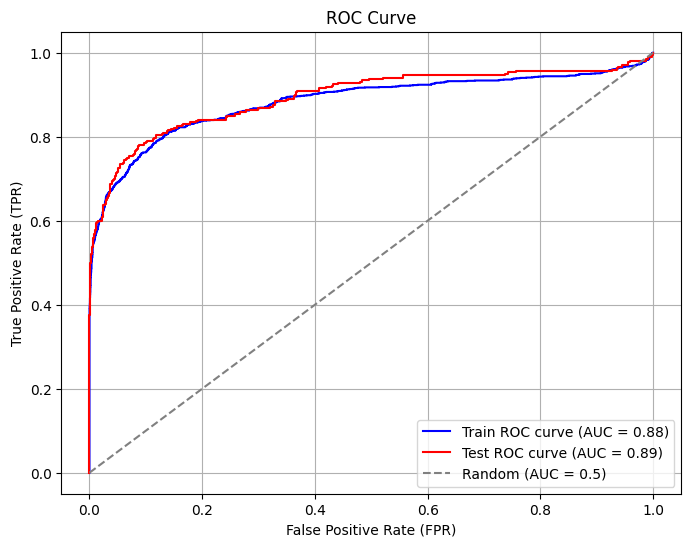

In [39]:
y_pred_proba_train = gs_log_reg.best_estimator_.predict_proba(X_train)[:, 1]
y_pred_proba_test = gs_log_reg.best_estimator_.predict_proba(X_test)[:, 1]

print("ROC score on train: ", roc_auc_score(y_true= y_train, y_score= y_pred_proba_train))
print("ROC score on test: ", roc_auc_score(y_true= y_test, y_score= y_pred_proba_test))

fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='Train ROC curve (AUC = %.2f)' % roc_auc_score(y_train, y_pred_proba_train))
plt.plot(fpr_test, tpr_test, color='red', label='Test ROC curve (AUC = %.2f)' % roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random (AUC = 0.5)")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

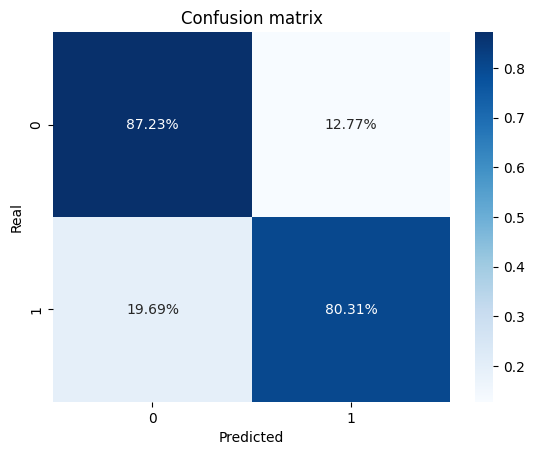

In [40]:
sns.heatmap(confusion_matrix(y_true= y_test, y_pred= gs_log_reg.best_estimator_.predict(X_test), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title("Confusion matrix");

### Conclusions for logistic regression:

After applying a grid search with a set of hyperparametres we have come to the conclusion that the model behaves pretty well in terms of recall in both train and test sets in all of the metrics evaluated. Our objective was not to omit the identification of true positives, even if we sacrifice some false positives. Regarding this approach, the recall score obtained is around 0.8, as well as the ROC score, which obtained values around 0.9

It is true that we see an imbalance between recall and F1 score, which tries to armonise both precision and recall, which suggests that our model is clasifying some negatives as positives.

## Random Forest

In [55]:
ran_for = RandomForestClassifier()

ran_for_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap' : [True, False]
}

gs_ran_for = GridSearchCV(
    estimator= ran_for,
    param_grid= ran_for_params,
    cv= 2,
    verbose= 1,
    scoring= "recall"
)

In [56]:
gs_ran_for.fit(X_train, y_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
864 fits failed out of a total of 2592.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
864 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\ibai.valente\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666,

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=1)

In [57]:
print(gs_ran_for.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [58]:
print("F1 score on train: ", f1_score(y_true= y_train, y_pred= gs_ran_for.best_estimator_.predict(X_train)))
print("F1 score on test: ", f1_score(y_true= y_test, y_pred= gs_ran_for.best_estimator_.predict(X_test)))

print("Recall on train: ", recall_score(y_true= y_train, y_pred= gs_ran_for.best_estimator_.predict(X_train)))
print("Recall on test: ", recall_score(y_true= y_test, y_pred= gs_ran_for.best_estimator_.predict(X_test)))

F1 score on train:  0.8318002628120894
F1 score on test:  0.7604166666666666
Recall on train:  0.9852140077821012
Recall on test:  0.9125


ROC score on train:  0.99574179981358
ROC score on test:  0.9792059850051706


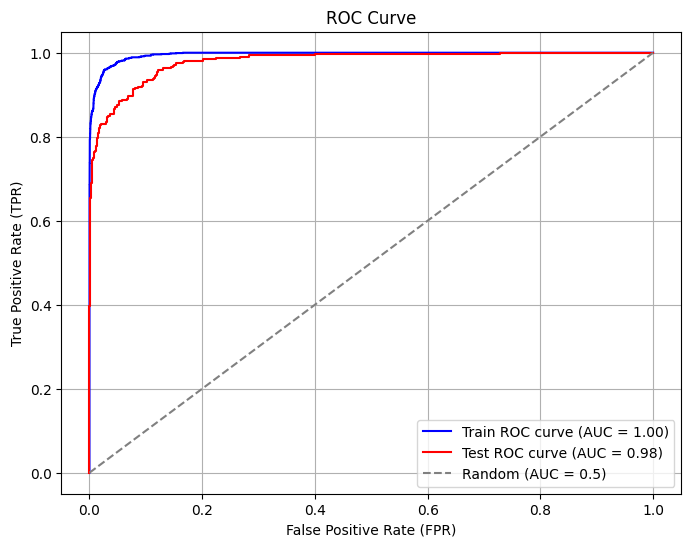

In [59]:
y_pred_proba_train = gs_ran_for.best_estimator_.predict_proba(X_train)[:, 1]
y_pred_proba_test = gs_ran_for.best_estimator_.predict_proba(X_test)[:, 1]

print("ROC score on train: ", roc_auc_score(y_true= y_train, y_score= y_pred_proba_train))
print("ROC score on test: ", roc_auc_score(y_true= y_test, y_score= y_pred_proba_test))

fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='Train ROC curve (AUC = %.2f)' % roc_auc_score(y_train, y_pred_proba_train))
plt.plot(fpr_test, tpr_test, color='red', label='Test ROC curve (AUC = %.2f)' % roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random (AUC = 0.5)")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

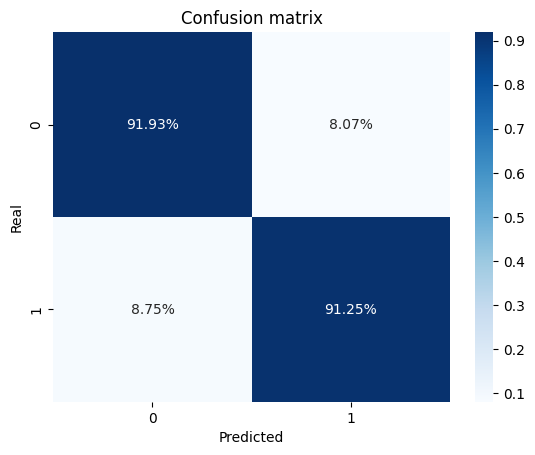

In [60]:
sns.heatmap(confusion_matrix(y_true= y_test, y_pred= gs_ran_for.best_estimator_.predict(X_test), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title("Confusion matrix");

As we can see, our random forest model improves the performance of the logistic regression. Recall obtained is above 0.9 both for train and test sets. When it comes to F1 score, we obtained 0.83 in train and 0.76 in test. This means that the balance between accuracy and recall improved compared to the previous model, however we must be careful with overfitting, as the difference between train and test results are increasing as our models get more complex. ROC curve results are pretty great as well. Finally, regarding the confusion matrix we perceive that our results are clearly improving.

With regard to random forest models, it is interesing to examine which variables are being more relevant when it comes to predictions. Let's analyse this.

In [61]:
feature_importances = gs_ran_for.best_estimator_.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df)

                   Feature  Importance
1              Torque [Nm]    0.545017
2          Tool wear [min]    0.201774
0  Process temperature [K]    0.110192
4                   Type_L    0.057553
5                   Type_M    0.046159
3                   Type_H    0.039305


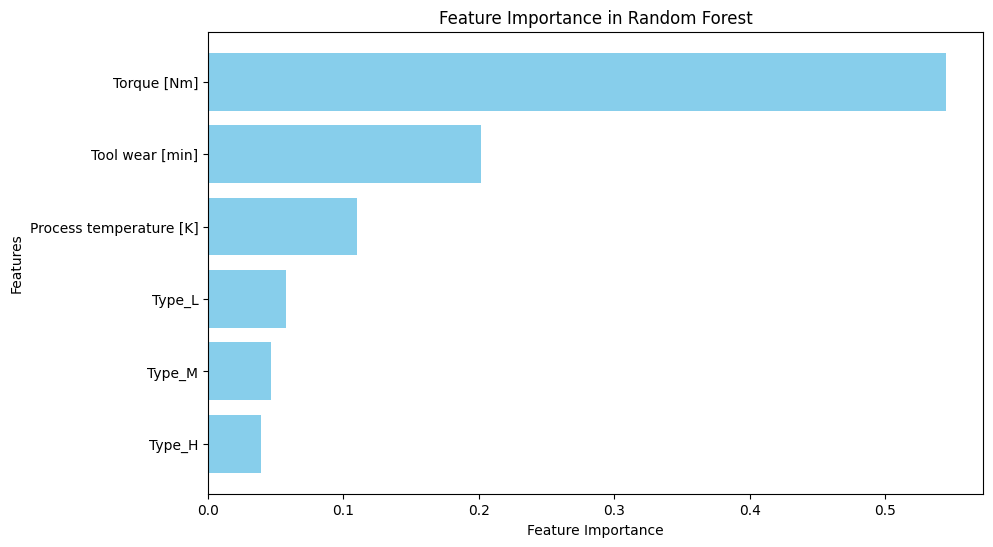

In [62]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

As can be seen, Torque is clearly the most important feature for our random forest model, implying that changes in torque would be very relevant for the model in order to determine if the machine is likely to fail. On the other hand, our dummy variables explain so little of the model's variance, meaning that we could obtain similar results even if we did not have this kind of information. In terms of resource optimisation, given this situation where three variables provide so little information to our model, we could study eliminating them in order to save computation resources. However, since our dataset is not especially large as far as the amount of variables is concerned, we believe that it is not worthy to eliminate any variable, even if the impact on the model's performance is not so evident.